In [1]:
import os
import numpy as np
import config
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [6]:
highres_transform = A.Compose(
    [
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        A.Normalize(mean=[0], std=[1]),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=[0], std=[1]),
        ToTensorV2(),
    ]
)

H_flip = A.Compose(
    [
        A.HorizontalFlip(p=1.0)
    ]
)

def rotate_image(image, times):
    rotated_image = np.copy(image)
    for _ in range(times):
        rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return rotated_image

data = []
root_dir = "/Users/qcx/My Drive/Python/LightField/Code/lightfield_mini/train"
class_names = os.listdir(root_dir)

for i, name in enumerate(class_names):
    if name == '.DS_Store':
        continue
    print(os.path.join(root_dir, name))
    files = os.listdir(os.path.join(root_dir, name))
    data += list(zip(files, [i] * len(files)))

index = 7
img_file, label = data[index]
gt_dir = os.path.join(root_dir, 'GT')
lf_dir = os.path.join(root_dir, 'LF')

# Open Images
high_res_image = Image.open(os.path.join(gt_dir, img_file))
low_res_sequence = tifffile.imread(os.path.join(lf_dir, img_file))
low_res_sequence = np.moveaxis(low_res_sequence, 0, -1)

# Randomly apply THE SAME augmentation to BOTH HR and LR
# operation = np.random.uniform(0, 1)
operation = 0.1
if operation <= 0.5:
    print("flip")
    results = []
    high_res_image = H_flip(image=np.array(high_res_image))["image"]
    for i in range(low_res_sequence.shape[2]):
        data = low_res_sequence[..., i]
        data = H_flip(image=data)["image"]
        results.append(data)
    low_res_sequence = np.stack(results, axis=-1)
if operation <= 0.25 or operation >= 0.75:
    times = np.random.randint(1, 5)
    print("R", times)
    results = []
    high_res_image = rotate_image(high_res_image, times)
    for i in range(low_res_sequence.shape[2]):
        data = low_res_sequence[..., i]
        data = rotate_image(data, times)
        results.append(data)
    low_res_sequence = np.stack(results, axis=-1)

high_res_image = highres_transform(image=np.array(high_res_image))["image"]
results = []
for i in range(low_res_sequence.shape[2]):
    data = low_res_sequence[..., i]
    data = lowres_transform(image=data)["image"]
    results.append(data)
low_res_sequence = np.stack(results, axis=-1)
print(np.shape(low_res_sequence))

/Users/qcx/My Drive/Python/LightField/Code/lightfield_mini/train/GT
/Users/qcx/My Drive/Python/LightField/Code/lightfield_mini/train/LF
flip
R 2
(1, 64, 64, 32)


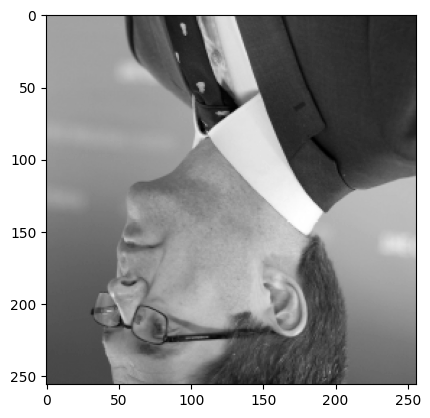

In [8]:
plt.imshow(high_res_image[0, :, :], cmap="gray")

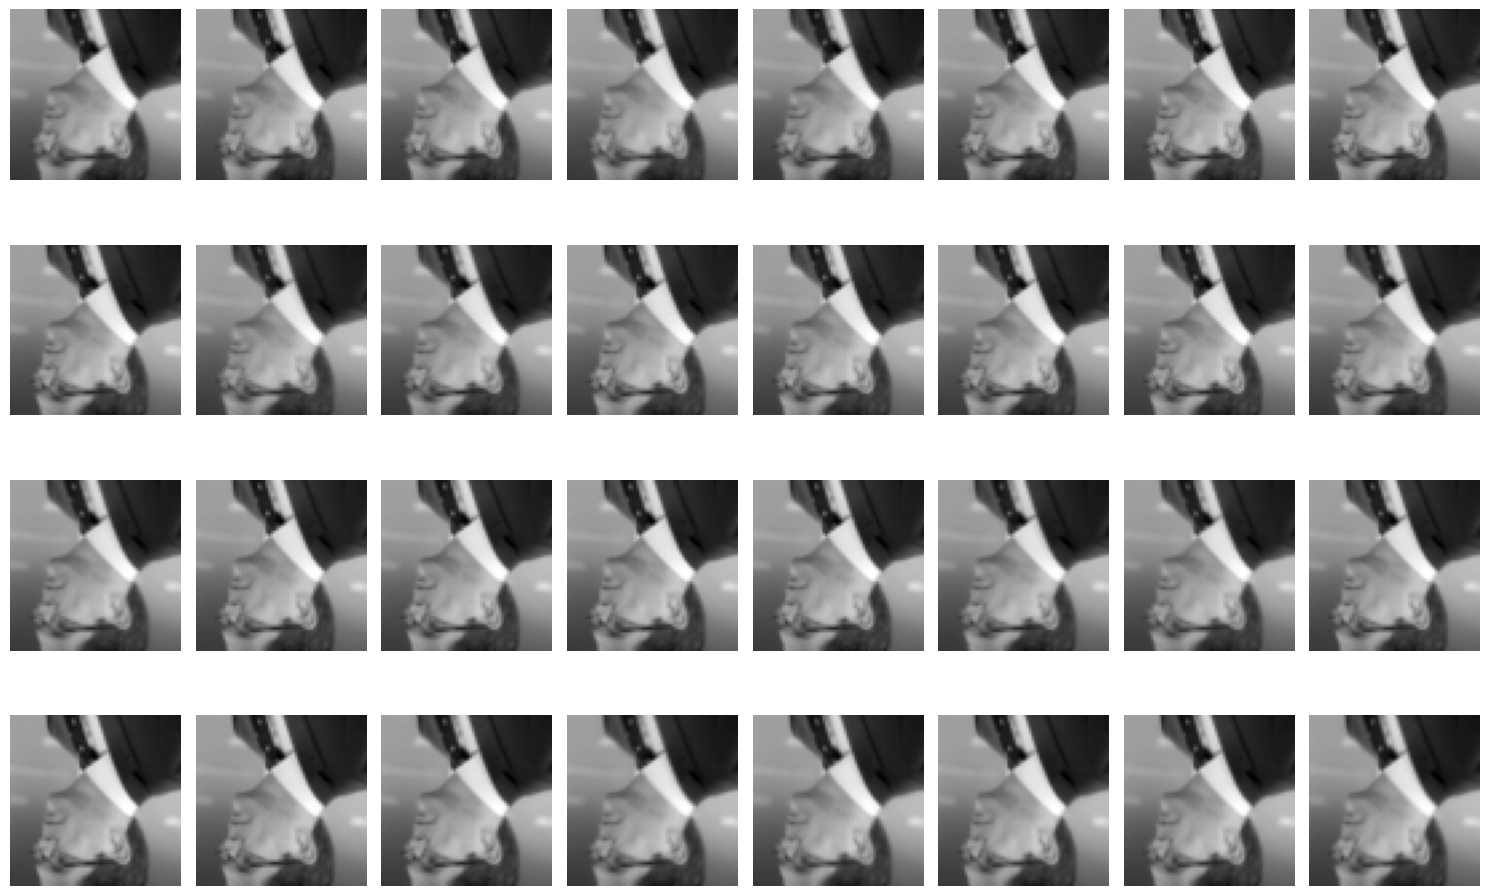

In [9]:
import matplotlib.pyplot as plt

# Assuming low_res_sequence is a 4D array
fig, axs = plt.subplots(4, 8, figsize=(15, 10))

for i in range(32):
    ax = axs[i // 8, i % 8]
    ax.imshow(low_res_sequence[0, :, :, i], cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()
